In [1]:
import sys
import os
from pathlib import Path

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

Internal imports   
The following cell ensures that the Python files in the `project_dir/code/` directory can be correctly imported by this notebook

In [2]:
# Add the project's `code` directory to the Python path
notebooks_dir = os.getcwd()
project_dir = os.path.dirname(notebooks_dir)
code_dir = os.path.join(project_dir, 'code')  
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

from my_utils import dict_from_disk, load_image_as_tensor
from cross_attention_dataset import CrossAttentionDataset
from probing_models import LinearProbe
from visualisation_utils import plot_masks_grid

Device

In [3]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

Reproducibility

In [4]:
torch.manual_seed(0)
np.random.seed(0)

if DEVICE.type == 'cuda':
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load cross-attention maps from disk

In [5]:
DATA_PATH = Path(r"C:\Users\aapolina\CODE\diffusion_segmentation\DATA\data\data\ECSSD_resized")

In [6]:
# Set the path to the directory containing the cross-attention maps
FEATURE_DIR = Path(f"{DATA_PATH}/features/cross_attn_cpu")

# Filter files in directory for the cross-attention maps
cross_attn_filenames = sorted([f for f in FEATURE_DIR.glob("*.h5") if f.stem.endswith("_cross")])

# Load the cross-attention maps
cross_attn_maps = [dict_from_disk(str(f)) for f in tqdm(cross_attn_filenames)]

100%|██████████| 1000/1000 [00:28<00:00, 35.00it/s]


In [7]:
GT_DIR = Path(f"{DATA_PATH}/gt")

# Load the ground truth masks for the cross-attention maps as (64, 64) tensors
base_names = map(lambda path: path.stem, cross_attn_filenames)
gt_paths = sorted([GT_DIR / f"{base_name.split('_')[0]}.png" for base_name in base_names])
gt_segmentations = [load_image_as_tensor(path, True) for path in gt_paths]

### Create a dataset and data loader from cross-attention maps

In [155]:
cross_attn_maps_train, cross_attn_maps_valid, gt_segmentations_train, gt_segmentations_valid = train_test_split(cross_attn_maps, gt_segmentations, test_size=0.2, random_state=0, shuffle=False)

In [156]:
dataset = CrossAttentionDataset(cross_attn_maps, gt_segmentations)

dataset_train = CrossAttentionDataset(cross_attn_maps_train, gt_segmentations_train)
data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)

dataset_valid = CrossAttentionDataset(cross_attn_maps_valid, gt_segmentations_valid)
data_loader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

### Train model

In [157]:
model = LinearProbe(n_timesteps=len(dataset_train.timesteps)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.BCELoss()

In [158]:
def evaluate_training(model,loader, criterion):
    loss_valid = []
    with torch.no_grad():
        
        for  cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in loader:
            cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)
            output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64).unsqueeze(0)


            loss = criterion(output, gt)
            loss_valid.append(loss.item())

    return loss_valid #np.mean(loss_valid)

In [159]:
losses_train = []
losses_valid = []

losses_train_all = []
losses_valid_all = []

for epoch in range(20):
    loss_epoch_train=[]

    with tqdm(data_loader_train, desc=f"Epoch {epoch}") as tepoch:
        for cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in tepoch:
            cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64).unsqueeze(0)
            loss = criterion(output, gt)
            loss_epoch_train.append(loss.item())

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update the progress bar description
            tepoch.set_description(f"Epoch {epoch}")# Loss: {loss.item():.4f}")

    loss_epoch_valid = evaluate_training(model, data_loader_valid, criterion)

    losses_train_all.append(loss_epoch_train) 
    losses_valid_all.append(loss_epoch_valid)
       
    loss_epoch_train = np.mean(loss_epoch_train)
    loss_epoch_valid = np.mean(loss_epoch_valid)

    losses_train.append(loss_epoch_train)
    losses_valid.append(loss_epoch_valid)  

    print(f"Epoch {epoch} \n Train Loss: {loss_epoch_train:.4f} \n Valid Loss: {loss_epoch_valid:.4f}")
    

Epoch 0:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 800/800 [00:06<00:00, 116.54it/s]


Epoch 0 
 Train Loss: 0.3732 
 Valid Loss: 0.3137


Epoch 1: 100%|██████████| 800/800 [00:05<00:00, 144.02it/s]


Epoch 1 
 Train Loss: 0.2640 
 Valid Loss: 0.2716


Epoch 2: 100%|██████████| 800/800 [00:05<00:00, 153.17it/s]


Epoch 2 
 Train Loss: 0.2336 
 Valid Loss: 0.2504


Epoch 3: 100%|██████████| 800/800 [00:05<00:00, 152.83it/s]


Epoch 3 
 Train Loss: 0.2157 
 Valid Loss: 0.2377


Epoch 4: 100%|██████████| 800/800 [00:05<00:00, 137.95it/s]


Epoch 4 
 Train Loss: 0.2038 
 Valid Loss: 0.2290


Epoch 5: 100%|██████████| 800/800 [00:05<00:00, 152.88it/s]


Epoch 5 
 Train Loss: 0.1953 
 Valid Loss: 0.2225


Epoch 6: 100%|██████████| 800/800 [00:05<00:00, 143.23it/s]


Epoch 6 
 Train Loss: 0.1888 
 Valid Loss: 0.2174


Epoch 7: 100%|██████████| 800/800 [00:05<00:00, 141.62it/s]


Epoch 7 
 Train Loss: 0.1836 
 Valid Loss: 0.2131


Epoch 8: 100%|██████████| 800/800 [00:05<00:00, 137.55it/s]


Epoch 8 
 Train Loss: 0.1794 
 Valid Loss: 0.2095


Epoch 9: 100%|██████████| 800/800 [00:05<00:00, 150.67it/s]


Epoch 9 
 Train Loss: 0.1759 
 Valid Loss: 0.2065


Epoch 10: 100%|██████████| 800/800 [00:05<00:00, 134.84it/s]


Epoch 10 
 Train Loss: 0.1731 
 Valid Loss: 0.2039


Epoch 11: 100%|██████████| 800/800 [00:05<00:00, 136.72it/s]


Epoch 11 
 Train Loss: 0.1706 
 Valid Loss: 0.2016


Epoch 12: 100%|██████████| 800/800 [00:06<00:00, 126.43it/s]


Epoch 12 
 Train Loss: 0.1684 
 Valid Loss: 0.1996


Epoch 13: 100%|██████████| 800/800 [00:06<00:00, 123.01it/s]


Epoch 13 
 Train Loss: 0.1665 
 Valid Loss: 0.1979


Epoch 14: 100%|██████████| 800/800 [00:06<00:00, 123.50it/s]


Epoch 14 
 Train Loss: 0.1649 
 Valid Loss: 0.1963


Epoch 15: 100%|██████████| 800/800 [00:06<00:00, 123.68it/s]


Epoch 15 
 Train Loss: 0.1634 
 Valid Loss: 0.1949


Epoch 16: 100%|██████████| 800/800 [00:06<00:00, 119.21it/s]


Epoch 16 
 Train Loss: 0.1621 
 Valid Loss: 0.1936


Epoch 17: 100%|██████████| 800/800 [00:06<00:00, 116.16it/s]


Epoch 17 
 Train Loss: 0.1609 
 Valid Loss: 0.1925


Epoch 18: 100%|██████████| 800/800 [00:05<00:00, 145.95it/s]


Epoch 18 
 Train Loss: 0.1598 
 Valid Loss: 0.1915


Epoch 19: 100%|██████████| 800/800 [00:05<00:00, 146.28it/s]


Epoch 19 
 Train Loss: 0.1589 
 Valid Loss: 0.1905


### Plot Train and Validation losses

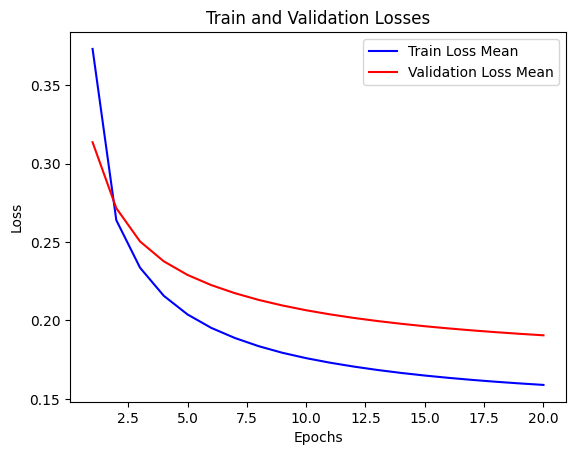

In [160]:
import matplotlib.pyplot as plt

epochs = range(1, len(losses_train) + 1)

plt.plot(epochs, losses_train, 'b', label='Train Loss Mean')
plt.plot(epochs, losses_valid, 'r', label='Validation Loss Mean')
plt.title('Train and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

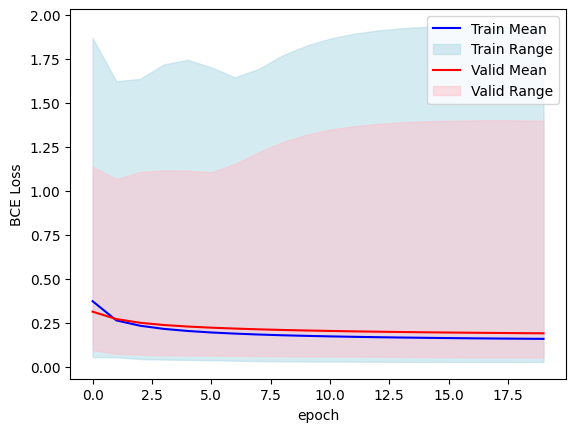

In [161]:
y_train = np.array(losses_train_all)
y_valid = np.array(losses_valid_all)

x = list(range(len(y_train)))
y_train_mean = np.mean(y_train, axis=1)
y_train_min = np.min(y_train, axis=1)
y_train_max = np.max(y_train, axis=1)
y_valid_mean = np.mean(y_valid, axis=1)
y_valid_min = np.min(y_valid, axis=1)
y_valid_max = np.max(y_valid, axis=1)

# Plot the line on the mean and shaded area of the range for training losses
plt.plot(x, y_train_mean, color='blue', label='Train Mean')
plt.fill_between(x, y_train_min, y_train_max, color='lightblue', alpha=0.5, label='Train Range')

# Plot the line on the mean and shaded area of the range for validation losses
plt.plot(x, y_valid_mean, color='red', label='Valid Mean')
plt.fill_between(x, y_valid_min, y_valid_max, color='pink', alpha=0.5, label='Valid Range')

# Add labels and legend
plt.xlabel('epoch')
plt.ylabel('BCE Loss')
plt.legend()

# Show the plot
plt.show()

In [181]:
def plot_img_output_gt(indices):

    fig, axs = plt.subplots(3, len(indices), figsize=(15, 5))

    for i, idx in enumerate(indices):
        img = load_image_as_tensor(gt_paths[idx].parent.parent / "img" / (gt_paths[idx].stem + ".jpg"))
        gt = load_image_as_tensor(gt_paths[idx], True)

        with torch.no_grad():
            cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt = dataset[idx]
            output = model(cross_attn_8.to(DEVICE), cross_attn_16.to(DEVICE),cross_attn_32.to(DEVICE), cross_attn_64.to(DEVICE))
            
            loss = criterion(output, gt.to(DEVICE)).cpu()
            output = output.squeeze().detach().cpu()

        axs[0, i].imshow(img.permute(1, 2, 0))
        axs[0, i].set_title(f"Image {idx}")

        axs[1, i].imshow(output)
        axs[1, i].set_title(f"Output {idx}: {loss:.4f}")

        axs[2, i].imshow(gt)
        axs[2, i].set_title(f"Ground Truth {idx}: {loss:.4f}")

    plt.tight_layout()
    plt.show()

Worst: [1.0699418783187866, 1.235835075378418, 1.9308475255966187] [[493, 118, 537]]
Best: [0.027770936489105225, 0.028105594217777252, 0.03071686439216137] [[336, 300, 255]]


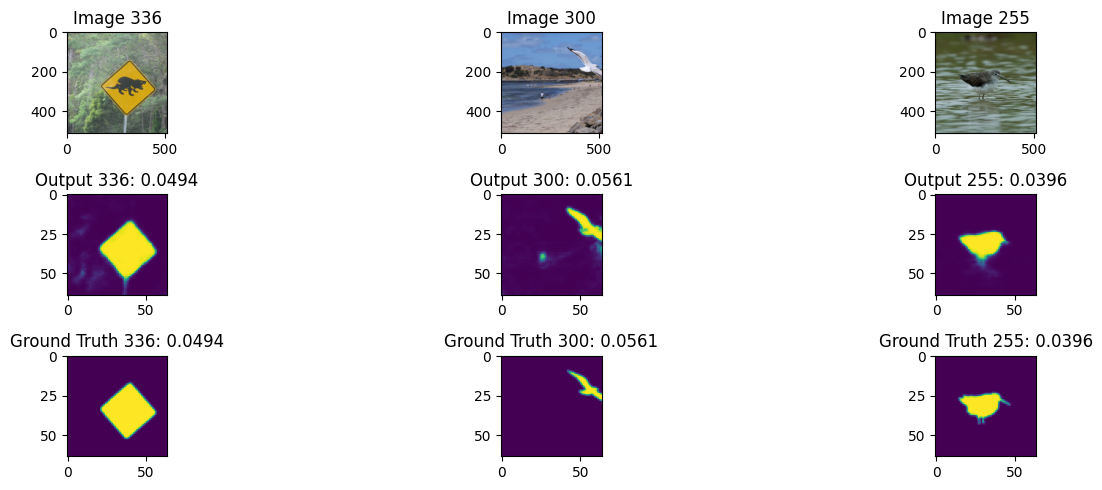

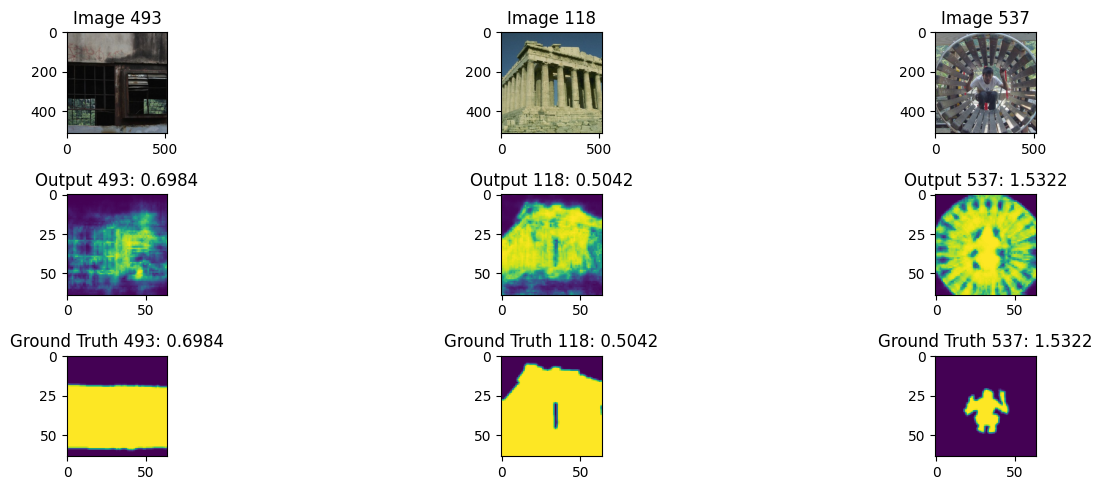

In [224]:
le = losses_train_all[19]
x = sorted(le)

best = [le.index(v) for v in  x[:3]]
worst = [le.index(v) for v in  x[-3:]]

print(f"Worst: {x[-3:]} [{worst}]\nBest: {x[:3]} [{best}]")

plot_img_output_gt(best)
plot_img_output_gt(worst)



# Save/Load the trained model to/from checkpoint

(saving the last state for now)

In [163]:
checkpoint_path = os.path.join(os.getcwd(), 'cross_attn_experiment.ckpt')

In [164]:
# save the model
torch.save(model.state_dict(), checkpoint_path)

In [165]:
# load model from checkpoint
model = LinearProbe(n_timesteps=len(dataset_train.timesteps)).to(DEVICE)
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

# Show the cross-attention maps

In [211]:
model.to(DEVICE)
DEVICE

device(type='cuda')

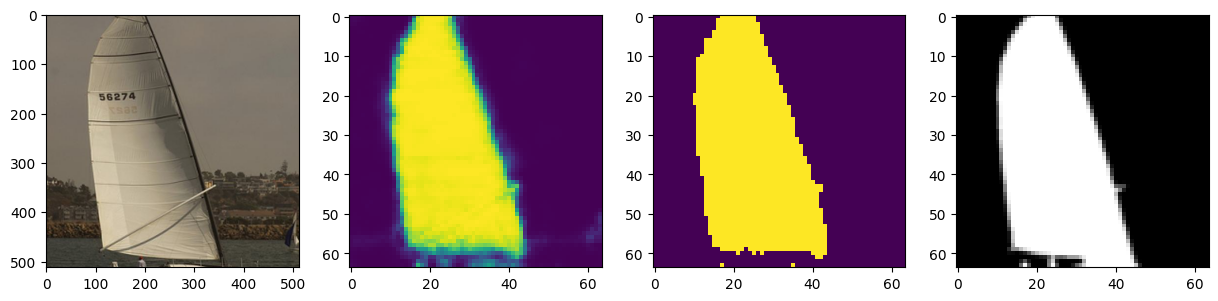

In [285]:
idx =77

img = load_image_as_tensor(gt_paths[idx].parent.parent / "img" / (gt_paths[idx].stem + ".jpg"))
gt = load_image_as_tensor(gt_paths[idx], True)

with torch.no_grad():
    cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, _ = dataset[idx]
    cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
    cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
    cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
    cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
    gt = gt.to(DEVICE)
    output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

img = img.cpu()
gt = gt.cpu()
output = output.cpu()   
output_binary = (output >= 0.5).float()


axs[0].imshow(img.permute(1, 2, 0))
axs[1].imshow(output)
axs[2].imshow(output_binary)
axs[3].imshow(gt, cmap='gray')



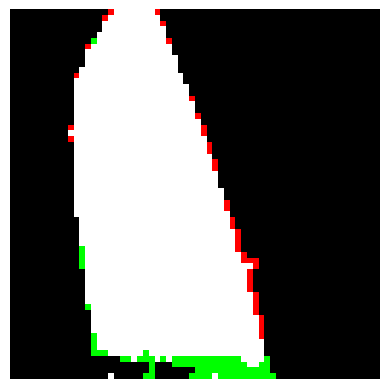

In [286]:
import numpy as np
import matplotlib.pyplot as plt

def plot_combined_image(image1, image2):
    combined_image = np.zeros((image1.shape[0], image1.shape[1], 3))

    # Set black pixels where both images have a value of 1
    combined_image[(image1 == 1) & (image2 == 1)] = [1,1,1]

    # Set white pixels where both images have a value of 0
    combined_image[(image1 == 0) & (image2 == 0)] = [0,0,0]

    # Set red pixels where the first image has a value of 1 and the second image has a value of 0
    combined_image[(image1 == 1) & (image2 == 0)] = [1, 0, 0]

    # Set green pixels where the first image has a value of 0 and the second image has a value of 1
    combined_image[(image1 == 0) & (image2 == 1)] = [0, 1, 0]

    plt.imshow(combined_image, cmap='gray')
    plt.axis('off')
    plt.show()


gt_binary = (gt>= 0.5).float()
plot_combined_image(output_binary, gt_binary)

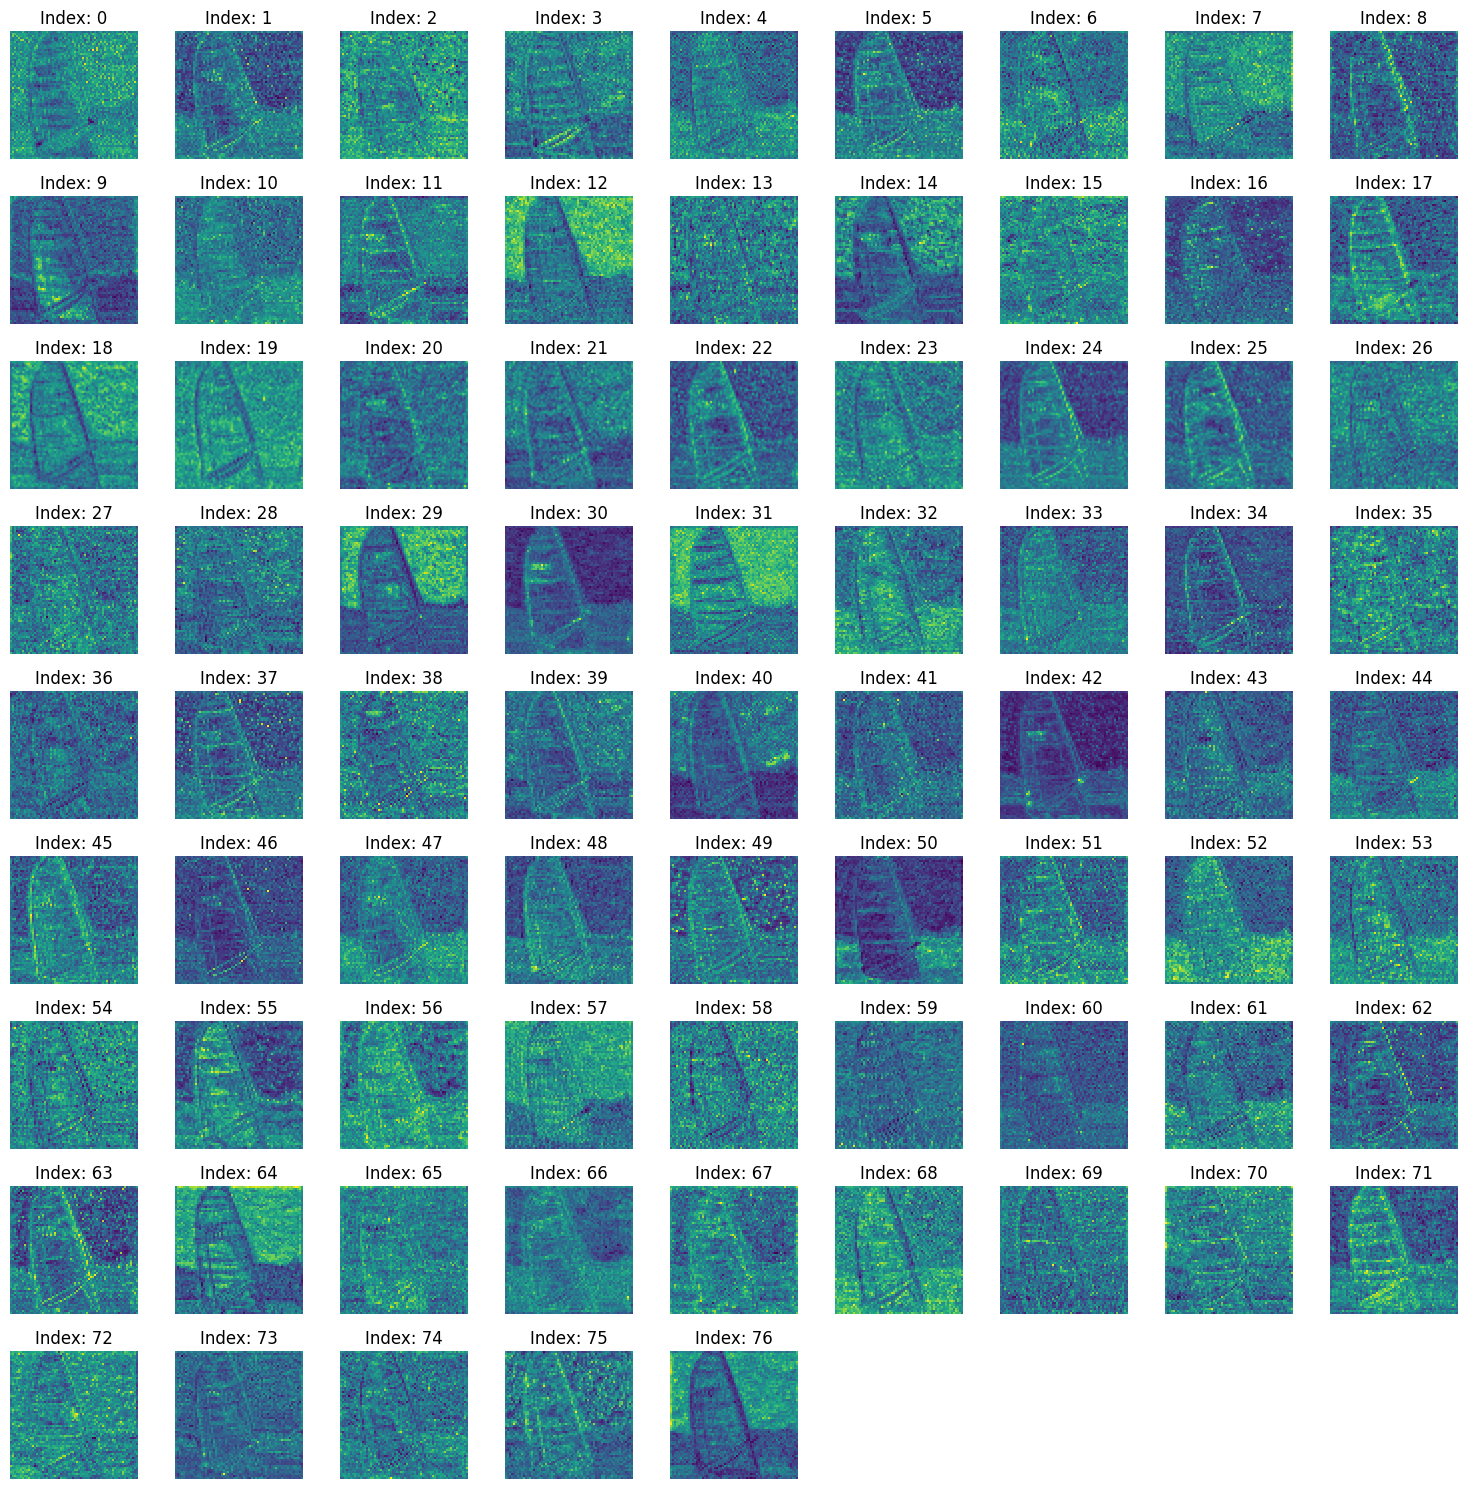

In [287]:
plot_masks_grid(cross_attn_64[0].cpu())

### Looking at the value ranges....

In [288]:
def tensor_range(x):
    print(f"Ouput range: [{torch.min(x)}, {torch.max(x)}]")

In [289]:
tensor_range(output)

Ouput range: [0.00027744652470573783, 0.9995394945144653]


In [290]:
tensor_range(gt)

Ouput range: [0.0, 1.0]


In [291]:
map = cross_attn_64
tensor_range(map)

Ouput range: [0.004772186279296875, 0.09674072265625]


In [292]:
def attn_maps_histograms(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64):
    fig, axs = plt.subplots(1,4, figsize=(10, 2.5))

    axs[0].hist(cross_attn_8.flatten(), bins=10)
    axs[0].set_title('cross_attn_8')

    axs[1].hist(cross_attn_16.flatten(), bins=10)
    axs[1].set_title('cross_attn_16')

    axs[2].hist(cross_attn_32.flatten(), bins=10)
    axs[2].set_title('cross_attn_32')

    axs[3].hist(cross_attn_64.flatten(), bins=10)
    axs[3].set_title('cross_attn_64')

    plt.tight_layout()
    plt.show()


In [293]:
#attn_maps_histograms(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64)


In [294]:
# x = cross_attn_64.flatten()
# tensor_range(x)

# x = torch.nn.functional.normalize(x, p=2, dim=0) #???
# tensor_range(x)

In [295]:
# x = cross_attn_64
# x = torch.nn.BatchNorm2d(num_features=77)(x.cpu().float())
# tensor_range(x)
# x = x.reshape(10,77, 64*64).detach()
# torch.mean(x, dim=2)

In [296]:
# x = cross_attn_64.cpu()
# x = x[0, 9]
# plt.imshow(x)

# x = cross_attn_64.cpu()
# x = x.flatten()
# x = x.reshape(10,77,64,64)
# x = x[0, 9]
# plt.imshow(x)


In [297]:
#import torchsummary
#torchsummary.summary(model = model, input_size=[(10,77,8,8), (10,77,16,16), (10,77,32,32), (10,77,64,64)], batch_size=1, device='cuda')
#torchsummary.summary(model,[(10,77,8,8), (10,77,16,16), (10,77,32,32), (10,77,64,64)])